In [1]:
from utils import calculate_weight_memory, calculate_kv_cache
from utils import convert_bytes_to_gigabytes, convert_bytes_to_megabytes
from constants import LLAMA3_400B_CONFIG
from name import TrainingConfig, Datatype, Transformer
from transformer_mem_functional import calculate_memory_requirements

In [2]:
{k: convert_bytes_to_gigabytes(v) for k, v in calculate_memory_requirements(
    transformer=Transformer(
        name="x",
        n_layers=44,
        hidden_size=6144,
        n_heads=64,
        n_key_value_heads=64,
        ctx_length=2048
    ),
    config=TrainingConfig(
    tp_size=1, pp_size=1, num_gpus=1,
    partition_activations=True, zero1=1,
    checkpoint_activations=True,
    batch_size_per_replicas=1,
    weight_dtype=Datatype.BFLOAT16,
    gradient_dtype=Datatype.BFLOAT16,
    optim_first_state_dtype=Datatype.FLOAT32,
    optim_second_state_dtype=Datatype.FLOAT32
)).items()}

{'Model Memory': '39.865 GB',
 'KV Cache Memory': '2.215 GB',
 'Gradient Memory': '39.865 GB',
 'Activation Memory': '18.824 GB',
 'Optimizer Memory': '239.189 GB',
 'Communication Memory': '3.000 GB',
 'Miscellaneous Memory': '0.000 GB',
 'Total Training Memory (GB)': '340.743 GB',
 'Total Inference Memory (GB)': '42.079 GB'}

In [3]:
{k: convert_bytes_to_gigabytes(v) for k, v in calculate_memory_requirements(
    transformer=Transformer(
        name="x",
        n_layers=44,
        hidden_size=6144,
        n_heads=64,
        n_key_value_heads=64,
        ctx_length=2048
    ),
    config=TrainingConfig(
    tp_size=1, pp_size=1, num_gpus=1,
    partition_activations=True,
    zero1=1,
    checkpoint_activations=True,
    batch_size_per_replicas=1,
    
    weight_dtype=Datatype.BFLOAT16,
    gradient_dtype=Datatype.BFLOAT16,
    
    optim_first_state_dtype=Datatype.FLOAT32,
    optim_second_state_dtype=Datatype.FLOAT32,
    master_weight_dtype=Datatype.FLOAT32,
)).items()}

{'Model Memory': '39.865 GB',
 'KV Cache Memory': '2.215 GB',
 'Gradient Memory': '39.865 GB',
 'Activation Memory': '18.824 GB',
 'Optimizer Memory': '239.189 GB',
 'Communication Memory': '3.000 GB',
 'Miscellaneous Memory': '0.000 GB',
 'Total Training Memory (GB)': '340.743 GB',
 'Total Inference Memory (GB)': '42.079 GB'}

In [2]:
{k: convert_bytes_to_gigabytes(v) for k, v in calculate_memory_requirements(
    transformer=Transformer(
        name="x",
        n_layers=44,
        hidden_size=6144,
        n_heads=64,
        n_key_value_heads=64,
        ctx_length=2048
    ),
    config=TrainingConfig(
    tp_size=1, pp_size=1, num_gpus=1,
    partition_activations=True,
    zero1=1,
    checkpoint_activations=True,
    batch_size_per_replicas=1,
    
    weight_dtype=Datatype.BFLOAT16,
    gradient_dtype=Datatype.BFLOAT16,
    
    optim_first_state_dtype=Datatype.FLOAT32,
    optim_second_state_dtype=Datatype.FLOAT32,
    master_weight_dtype=Datatype.FLOAT32,
)).items()}

{'Model Memory': '39.865 GB',
 'KV Cache Memory': '2.215 GB',
 'Gradient Memory': '39.865 GB',
 'Activation Memory': '18.824 GB',
 'Optimizer Memory': '239.189 GB',
 'Communication Memory': '3.000 GB',
 'Miscellaneous Memory': '0.000 GB',
 'Total Training Memory (GB)': '340.743 GB',
 'Total Inference Memory (GB)': '42.079 GB'}

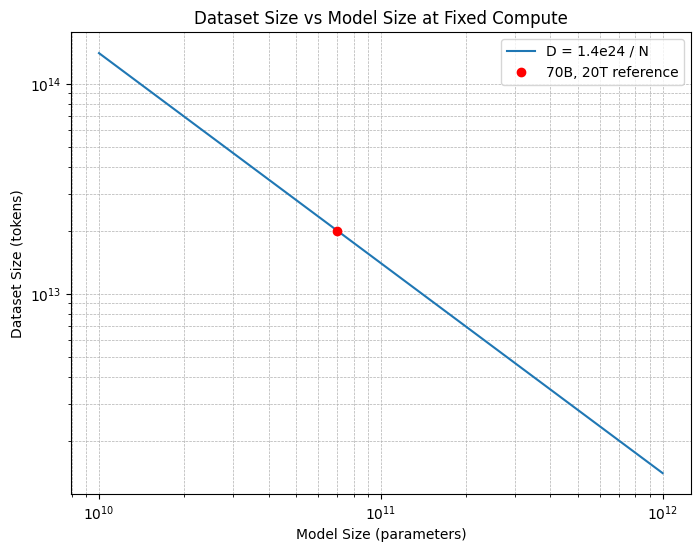

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Fixed compute and constants
C = 8.4e24  # total compute FLOPs from previous derivation
# D = (1.4e24) / N

# Define model sizes from 10B to 1T on a log scale
model_sizes = np.logspace(np.log10(1e10), np.log10(1e12), num=100)  # from 10B to 1T
tokens = 1.4e24 / model_sizes

plt.figure(figsize=(8,6))
plt.plot(model_sizes, tokens, label="D = 1.4e24 / N")

# Set both axes to log scale
plt.xscale('log', base=10)
plt.yscale('log', base=10)

# Add reference point for 70B and 20T
N_70B = 7e10
D_20T = 2e13
plt.plot(N_70B, D_20T, 'ro', label='70B, 20T reference')

plt.title("Dataset Size vs Model Size at Fixed Compute")
plt.xlabel("Model Size (parameters)")
plt.ylabel("Dataset Size (tokens)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.show()


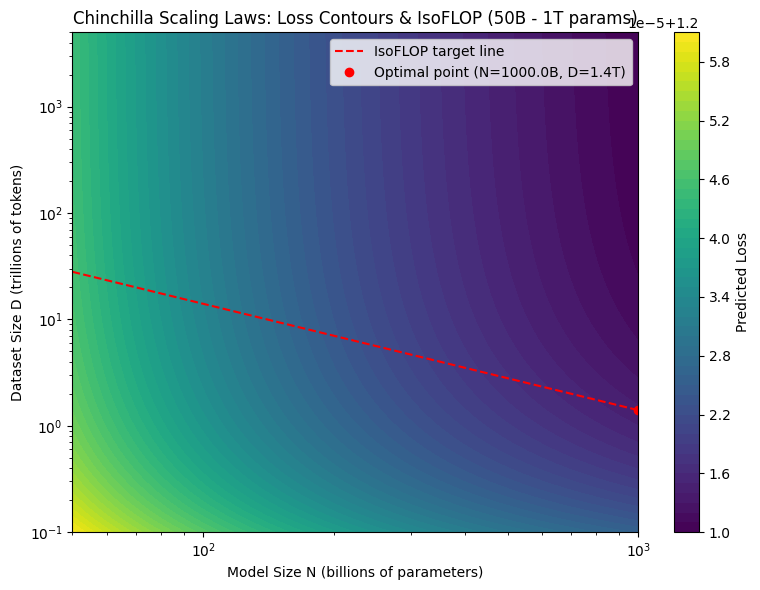

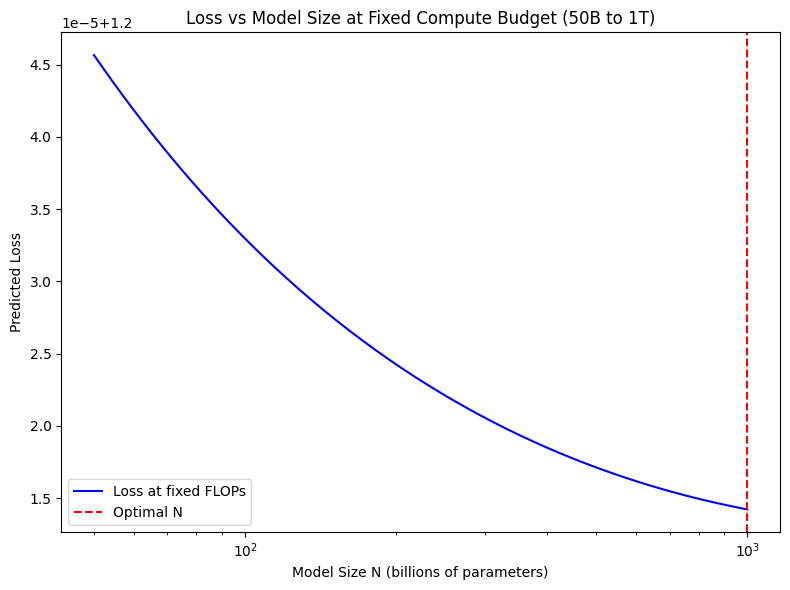

Optimal model size: 1000.00B params, Optimal dataset size: 1.40T tokens


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# --------------------------------------------------------------
# Example parameters (replace these with the actual values from the paper)
E = 1.2     # Entropy floor approximation (example)
A = 10.0    # Example coefficient for model-size term
B = 5.0     # Example coefficient for data-size term
alpha = 0.5
beta = 0.5

# FLOPs formula:
# FLOPs ≈ 6 * N * D
# N in parameters, D in tokens.

# Define the loss function according to the parametric form:
# L(N, D) = E + A/N^α + B/D^β
# N will be passed in absolute units (not billions), same for D.
def loss(N, D, E=E, A=A, B=B, alpha=alpha, beta=beta):
    return E + A / (N**alpha) + B / (D**beta)

# --------------------------------------------------------------
# Suppose we have a target FLOP budget (for demonstration):
# Let's say we consider the FLOPs budget equal to that for training a 70B model for 20T tokens.
FLOPs_target = 6.0 * 70e9 * 20e12  # 6 * (70 billion) * (20 trillion)

# We'll work in the following units:
# N in billions (B), D in trillions (T).
# Then FLOPs = 6 * N * D * (1e9 * 1e12) = 6 * N * D * 1e21 in absolute units.
# Define scaled units where FLOPs in these units = 6 * N * D.
FLOPs_target_scaled = FLOPs_target / 1e21

# Given FLOPs = 6 * N * D, we have D = FLOPs_target_scaled / (6*N)
def D_at_fixed_FLOP(N):
    return FLOPs_target_scaled / (6*N)

# --------------------------------------------------------------
# Range model size from 50B to 1T parameters
N_vals = np.geomspace(50, 1000, 200)  # N from 50B to 1000B (1T)
D_vals = np.geomspace(0.1, 5000, 200) # D from 0.1T to 5000T

N_grid, D_grid = np.meshgrid(N_vals, D_vals)

# Compute loss on the grid
# Convert N_grid,B->params and D_grid,T->tokens
L_grid = loss(N_grid*1e9, D_grid*1e12, E, A, B, alpha, beta)

# Compute Loss along isoFLOPs line:
D_iso = D_at_fixed_FLOP(N_vals)
L_iso = loss(N_vals*1e9, D_iso*1e12, E, A, B, alpha, beta)

# Find optimal N on the isoFLOP line
min_idx = np.argmin(L_iso)
N_opt = N_vals[min_idx]
D_opt = D_iso[min_idx]

# --------------------------------------------------------------
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Contour plot of loss
cs = ax.contourf(N_grid, D_grid, L_grid, levels=50, cmap='viridis')
cbar = plt.colorbar(cs, ax=ax)
cbar.set_label('Predicted Loss')

# IsoFLOP line
ax.plot(N_vals, D_iso, 'r--', label='IsoFLOP target line')

# Optimal point
ax.plot(N_opt, D_opt, 'ro', label=f'Optimal point (N={N_opt:.1f}B, D={D_opt:.1f}T)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Model Size N (billions of parameters)')
ax.set_ylabel('Dataset Size D (trillions of tokens)')
ax.set_title('Chinchilla Scaling Laws: Loss Contours & IsoFLOP (50B - 1T params)')
ax.legend()

plt.tight_layout()
plt.show()

# 1D slice plot: Loss vs N at fixed FLOPs
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(N_vals, L_iso, label='Loss at fixed FLOPs', color='blue')
ax.axvline(x=N_opt, color='red', linestyle='--', label='Optimal N')
ax.set_xscale('log')
ax.set_xlabel('Model Size N (billions of parameters)')
ax.set_ylabel('Predicted Loss')
ax.set_title('Loss vs Model Size at Fixed Compute Budget (50B to 1T)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Optimal model size: {N_opt:.2f}B params, Optimal dataset size: {D_opt:.2f}T tokens")
